In [1]:
# 1. Install dependencies
!pip install selenium webdriver-manager pandas openpyxl

# 2. Imports
import time, random
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# 3. WebDriver Setup (Non-Headless for manual login)
def make_driver():
    options = Options()
    # Headless disabled: window will open for manual login
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.set_page_load_timeout(30)
    return driver

# 4. Build LinkedIn Search URL
def build_search_url(keywords, location="Worldwide", posted_days=7):
    base = "https://www.linkedin.com/jobs/search/?"
    q = f"keywords={keywords.replace(' ', '%20')}&location={location.replace(' ', '%20')}"
    if posted_days:
        q += f"&f_TPR=r{posted_days * 24 * 60}"
    return base + q

# 5. Collect Job Links
def get_job_links(driver, search_url, max_pages=2, sleep_range=(2,5)):
    driver.get(search_url)
    links = set()
    wait_long = lambda driver: WebDriverWait(driver, 20)

    for page in range(max_pages):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight/3);")
        time.sleep(2)
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(3)

        # Try selectors for job list
        selectors = [
            "ul.scaffold-layout__list-container li",
            "div.jobs-search-results__list-item",
            "div.base-card"
        ]
        job_cards = []
        for sel in selectors:
            try:
                job_cards = wait_long(driver).until(
                    EC.presence_of_all_elements_located((By.CSS_SELECTOR, sel))
                )
                if job_cards:
                    break
            except:
                pass
        if not job_cards:
            print(f"No job cards found on page {page+1}")
            continue

        # Get job links
        for sel in ["a.base-card__full-link", "a.job-card-container__link", "a.job-card-list__title"]:
            candidates = driver.find_elements(By.CSS_SELECTOR, sel)
            if candidates:
                break
        for a in candidates:
            href = a.get_attribute("href")
            if href and "/jobs/view/" in href:
                links.add(href.split("?")[0])  # Fix: use string, not list


        # Next page
        try:
            next_btn = driver.find_element(By.CSS_SELECTOR, "button[aria-label='Next']")
            if not next_btn.is_enabled():
                break
            driver.execute_script("arguments.click();", next_btn)
            time.sleep(random.uniform(*sleep_range))
        except:
            break

    return list(links)

# 6. Scrape Job Details
def scrape_job_page(driver, url, sleep_range=(2,5)):
    driver.get(url)
    wait_long = lambda driver: WebDriverWait(driver, 20)
    # Wait for job card
    try:
        wait_long(driver).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.jobs-unified-top-card, div.top-card-layout"))
        )
    except:
        time.sleep(2)

    # Expand description
    try:
        see_more = driver.find_element(By.CSS_SELECTOR, "button[aria-label^='See more'], button[aria-label^='Show more']")
        driver.execute_script("arguments.click();", see_more)
        time.sleep(1)
    except:
        pass

    def find_text(selectors_css, selectors_xpath=()):
        for sel in selectors_css:
            try:
                el = driver.find_element(By.CSS_SELECTOR, sel)
                if el.text.strip():
                    return el.text.strip()
            except:
                pass
        for xp in selectors_xpath:
            try:
                el = driver.find_element(By.XPATH, xp)
                if el.text.strip():
                    return el.text.strip()
            except:
                pass
        return ""

    title = find_text([
        "h1.top-card-layout__title",
        "h1[data-test-id='job-details-top-card__job-title']",
        "h1"
    ])
    company = find_text([
        "a.topcard__org-name-link",
        "a[data-test-id='job-details-top-card__company-url']",
        "span.topcard__flavor"
    ])
    location = find_text([
        "span.topcard__flavor--bullet",
        "span.job-details-jobs-unified-top-card__primary-description"
    ])
    posted = find_text([
        "span.posted-time-ago__text",
        "span[data-test-id='job-details-top-card__flavor--metadata posted-time-ago']"
    ])
    insights = " | ".join([
        el.text.strip() for el in driver.find_elements(By.CSS_SELECTOR, "li.jobs-unified-top-card__job-insight")
    ])
    description = find_text([
        "div.show-more-less-html__markup",
        "section.description div"
    ], selectors_xpath=[
        "//div[contains(@class,'show-more-less-html__markup')]"
    ])

    # Basic skill extraction
    common_skills = [
        "python","java","c++","sql","excel","javascript","html","css","react","angular",
        "node","aws","azure","gcp","docker","kubernetes","git","linux","agile","scrum"
    ]
    found_skills = [s for s in common_skills if s in description.lower()]
    skills = ", ".join(found_skills)
    time.sleep(random.uniform(*sleep_range))
    return {
        "Job Title": title,
        "Company": company,
        "Location": location,
        "Posted": posted,
        "Insights": insights,
        "Job Description": description,
        "Skills": skills,
        "Job URL": url
    }

# 7. MAIN: Manual Login + Scrape Multiple Roles
ROLES = [
    "Data Analyst","Business Analyst","Software Engineer","Data Scientist","Machine Learning Engineer",
    "Financial Analyst","Marketing Analyst","Product Manager","Human Resources Manager","Project Manager"
]
LOCATION = "India"
PAGES = 2
OUTPUT_CSV = "linkedin_jobs_multi_roles.csv"
all_rows = []

driver = make_driver()
driver.get("https://www.linkedin.com/login")
input("Log in to LinkedIn manually, then press Enter here to continue...")

for role in ROLES:
    print(f"\nScraping role: {role}")
    search_url = build_search_url(role, LOCATION, posted_days=7)
    links = get_job_links(driver, search_url, max_pages=PAGES)
    print(f"Collected {len(links)} job links for {role}")
    for i, url in enumerate(links, 1):
        try:
            data = scrape_job_page(driver, url)
            data["Role"] = role
            all_rows.append(data)
            print(f"[{i}/{len(links)}] {data['Job Title']} - {data['Company']}")
        except Exception as e:
            print(f"Error scraping {url}: {e}")

driver.quit()
df = pd.DataFrame(all_rows)
df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
print(f"\nSaved combined results to {OUTPUT_CSV}")

Log in to LinkedIn manually, then press Enter here to continue... 



Scraping role: Data Analyst
Collected 60 job links for Data Analyst
[1/60] Data Analyst Intern - UM IT Solutions
[2/60] Senior Specialist – Cloud Engineering - S M Software Solutions Inc
[3/60] Wordpress Developer - Mindor.Tech
[4/60] Development Engineer, India - AlgoSec
[5/60] Web Developer Intern - UM IT Solutions
[6/60] Senior Specialist – Cloud Engineering - S M Software Solutions Inc
[7/60] Junior android developer - Koogle®
[8/60] Data Analyst Intern - UM IT Solutions
[9/60] Frontend Developer - Symfor
[10/60] Web Developer Intern - UM IT Solutions
[11/60] Cloud Engineer - Ramrashi Solutions LLP
[12/60] Senior Specialist – Cloud Engineering - S M Software Solutions Inc
[13/60] Senior Specialist – Cloud Engineering - S M Software Solutions Inc
[14/60] Data Analytics - Deputy Manager - Allianz Partners
[15/60] Web Developer Intern - UM IT PRIVATE LIMITED
[16/60] Senior Specialist – Cloud Engineering - S M Software Solutions Inc
[17/60] Data Analyst Trainee - Mdtresy Medical Trave

In [ ]:
# Data Cleaning

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\Abhi Singh Yadav\OneDrive\Documents\Internship Elevate Labs\Project\Cleaned_linkedin_jobs_finalDatset.csv")
print(df.shape)
print(df.head())

(1107, 6)
                               Job Title                     Company  \
0                    Data Analyst Intern             UM IT Solutions   
1  Senior Specialist – Cloud Engineering  S M Software Solutions Inc   
2                    Wordpress Developer                 Mindor.Tech   
3                 Development Engineer                       AlgoSec   
4                   Web Developer Intern             UM IT Solutions   

                 Location       Skill          Role       City  
0                   India           r  Data Analyst      Delhi  
1  Bengaluru, Karnataka    kubernetes  Data Analyst  Bengaluru  
2  Bengaluru, Karnataka             r  Data Analyst  Bengaluru  
3      New Delhi, Delhi         go, r  Data Analyst  New Delhi  
4                   India           r  Data Analyst      Delhi  


In [2]:
# Drop duplicates
df = df.drop_duplicates()

# Check missing values
print(df.isnull().sum())

# Fill or drop missing values
df['Skill'] = df['Skill'].fillna("")
df['Location'] = df['Location'].fillna("Unknown")


Job Title    0
Company      0
Location     0
Skill        0
Role         0
City         0
dtype: int64


In [3]:
# Split skills into lists
df['Skill'] = df['Skill'].str.lower().str.replace(" ", "")
df['Skill'] = df['Skill'].str.split(",")

# Example of standardizing
skill_map = {
    "ml": "machine learning",
    "python3": "python",
    "rprog": "r"
}

df['Skill'] = df['Skill'].apply(lambda skills: [skill_map.get(s, s) for s in skills])


In [4]:
# Keep only city
df['City'] = df['Location'].apply(lambda x: x.split(",")[0] if pd.notnull(x) else "Unknown")

# Replace generic entries
df['City'] = df['City'].replace(["India"], "Unknown")


In [5]:
print(df['Role'].value_counts())

# Example: fix inconsistent naming
df['Role'] = df['Role'].str.strip().str.title()


Role
Software Engineer                                        161
Data Scientist                                           161
Data Analyst                                             158
Financial Analyst                                        121
Machine Learning Engineer                                117
Marketing Analyst                                        101
Product Manager                                           95
Business Analyst                                          93
Project Manager                                           53
Human Resources Manager                                   34
Data Analyst, Predictive Analytics, India- X Delivery      1
Reporting Analyst                                          1
Associate Data Analyst                                     1
Business Intelligence Analyst                              1
Analyst, Data Analytics                                    1
Role                                                       1
Sr Analyst, Data An

In [6]:
df.to_csv("Cleaned_linkedin_jobs_finalDatset", index=False)

In [ ]:
#EDA(exploratory Data Analysis)

In [7]:
import pandas as pd
df1=pd.read_csv(r"C:\Users\Abhi Singh Yadav\OneDrive\Documents\Internship Elevate Labs\Project\Cleaned_linkedin_jobs_finalDatset.csv")
df1.head()

,Job Title,Company,Location,Skill,Role,City
0,Data Analyst Intern,UM IT Solutions,India,r,Data Analyst,Delhi
1,Senior Specialist – Cloud Engineering,S M Software Solutions Inc,"Bengaluru, Karnataka",kubernetes,Data Analyst,Bengaluru
2,Wordpress Developer,Mindor.Tech,"Bengaluru, Karnataka",r,Data Analyst,Bengaluru
3,Development Engineer,AlgoSec,"New Delhi, Delhi","go, r",Data Analyst,New Delhi
4,Web Developer Intern,UM IT Solutions,India,r,Data Analyst,Delhi


In [8]:
# Find where more jobs are posted
df1['City'].value_counts().head(10)

City
Bengaluru        121
Mumbai            77
United States     68
Pune              64
Hyderabad         56
Chennai           48
Gurugram          38
New Delhi         35
Gurgaon           24
Delhi             24
Name: count, dtype: int64

In [9]:
skills_exploded = df.explode('Skill')
skills_exploded['Skill'].value_counts().head(15)


Skill
r                    695
excel                407
sql                  290
python               263
go                   208
git                  129
agile                123
communication        122
aws                  114
powerbi              111
java                 109
datavisualization     98
deeplearning          89
nlp                   84
analytics             82
Name: count, dtype: int64

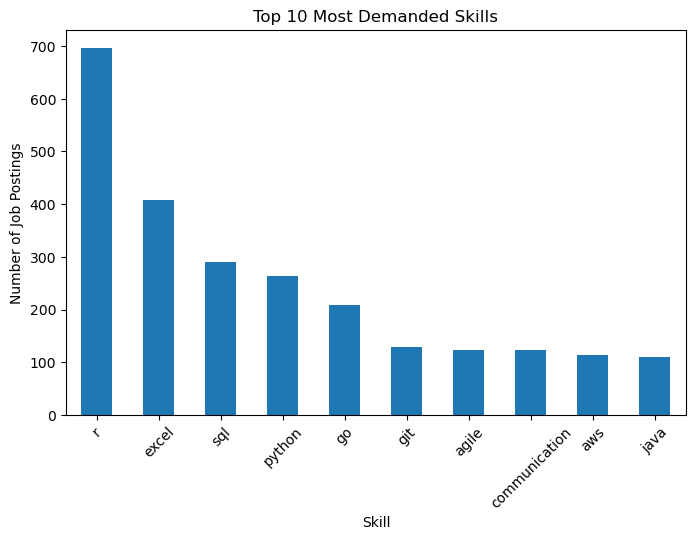

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset again
df1= pd.read_csv(r"C:\Users\Abhi Singh Yadav\OneDrive\Documents\Internship Elevate Labs\Project\Cleaned_linkedin_jobs_finalDatset.csv")

# Ensure Skill column is string
df1['Skill'] = df1['Skill'].astype(str)

# Split skills by comma, strip spaces, convert to lowercase
df1['Skill'] = df1['Skill'].str.lower().str.split(',')

# Expand each skill into a new row
df_exploded = df1.explode('Skill')

# Clean spaces around skill names
df_exploded['Skill'] = df_exploded['Skill'].str.strip()

# Count top 10 skills
top_skills = df_exploded['Skill'].value_counts().head(10)

# Plot clean version
top_skills.plot(kind='bar', figsize=(8,5))
plt.title("Top 10 Most Demanded Skills")
plt.xlabel("Skill")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
plt.show()


City
Bengaluru        121
Mumbai            77
United States     68
Pune              64
Hyderabad         56
Chennai           48
Gurugram          38
New Delhi         35
Gurgaon           24
Delhi             24
Name: count, dtype: int64


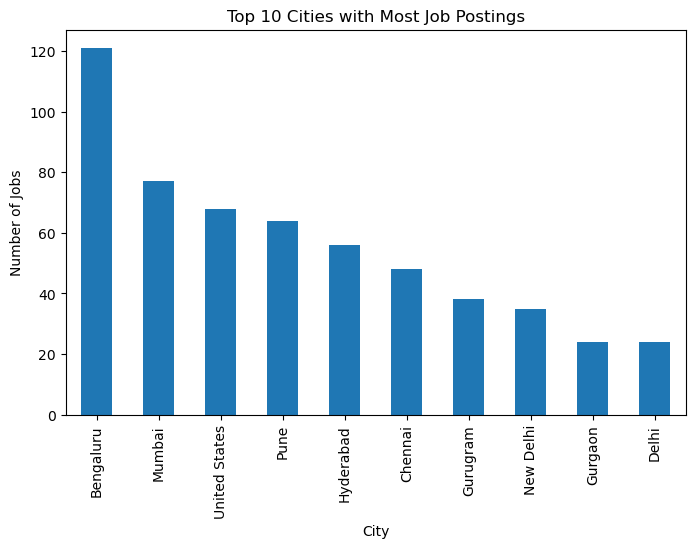

In [12]:
# Count jobs per city
top_cities = df1['City'].value_counts().head(10)
print(top_cities)

# Plot
top_cities.plot(kind='bar', figsize=(8,5))
plt.title("Top 10 Cities with Most Job Postings")
plt.ylabel("Number of Jobs")
plt.show()

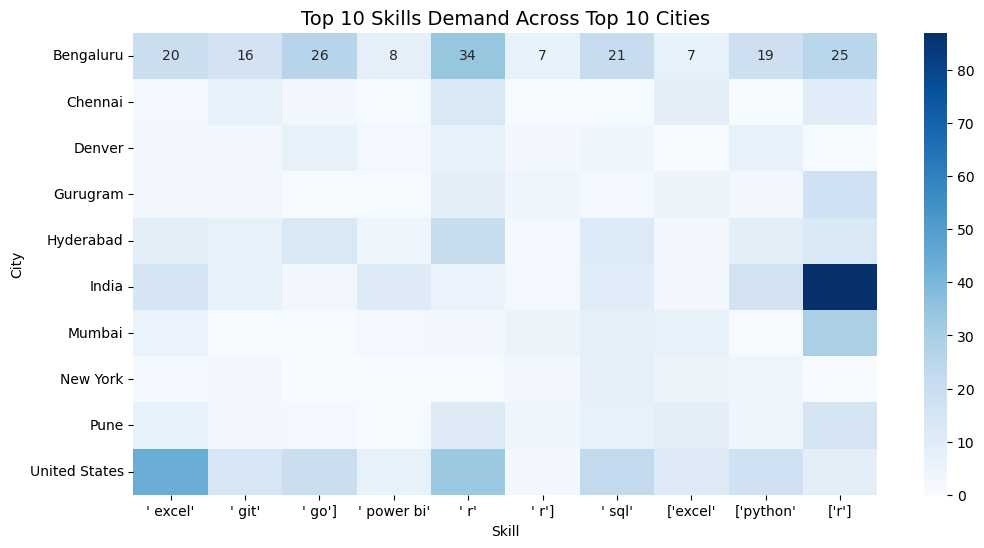

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Clean Skills ---
df1['Skill'] = df1['Skill'].astype(str).str.lower().str.split(',')
df1 = df1.explode('Skill')
df1['Skill'] = df1['Skill'].str.strip()

# --- Clean City (take only first part of Location) ---
df1['City'] = df1['Location'].astype(str).str.split(',').str[0].str.strip()

# --- Filter Top Cities and Skills ---
top10_cities = df1['City'].value_counts().head(10).index
top10_skills = df1['Skill'].value_counts().head(10).index

# Pivot table for heatmap
heatmap_data = df1[df1['City'].isin(top10_cities) & df1['Skill'].isin(top10_skills)]
pivot = heatmap_data.pivot_table(index='City', columns='Skill', aggfunc='size', fill_value=0)

# --- Plot Heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Blues", annot=True, fmt="d")
plt.title("Top 10 Skills Demand Across Top 10 Cities", fontsize=14)
plt.ylabel("City")
plt.xlabel("Skill")
plt.show()


In [19]:

# --- Clean Skills ---
df1['Skill'] = df1['Skill'].astype(str).str.lower().str.split(',')
df1 = df1.explode('Skill')
df1['Skill'] = df1['Skill'].str.strip()

# --- Clean Role Column ---
df1['Role'] = df1['Role'].astype(str).str.strip()

# --- Build Matrix ---
role_skill_matrix = df1.pivot_table(index='Role', 
                                   columns='Skill', 
                                   aggfunc='size', 
                                   fill_value=0)

# --- Keep only Top 10 Skills ---
top10_skills = df1['Skill'].value_counts().head(10).index
role_skill_matrix = role_skill_matrix[top10_skills]

# Show matrix
print(role_skill_matrix.head(10))

# Save to CSV for dashboard/report use
role_skill_matrix.to_csv("Roles_vs_Skills_Matrix.csv")

Skill                                               ['r']  ' excel'  ' r'  \
Role                                                                        
Analyst, Data Analytics                                 0         1     1   
Analyst, Trust And Safety                               0         1     1   
Associate Data Analyst                                  0         0     1   
Business Analyst                                       18        59    20   
Business Intelligence Analyst                           0         1     1   
Data Analyst                                           38        84    56   
Data Analyst, Mumbai                                    0         0     1   
Data Analyst, Predictive Analytics, India- X De...      0         1     1   
Data Engineer I                                         1         0     0   
Data Scientist                                         44        12    43   

Skill                                               ' sql'  ['python'  ' go